# Estimation of RI Model through Adaptive SMC

Author: Daniel Csaba

Date: September 2018


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.linalg import block_diag
import statsmodels.api as sm
from patsy import dmatrix
import time
from numba import jit, float64


sns.set_style('whitegrid')
colors = sns.color_palette()

# use latex and set font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
# import cleaned dataset -- wide format
df = pd.read_pickle('../Data/df_cov_TM.pkl')

df.head()

,air_choice,air_gcost,air_travel,air_vcost,air_wait,bus_choice,bus_gcost,bus_travel,bus_vcost,bus_wait,...,car_vcost,car_wait,train_choice,train_gcost,train_travel,train_vcost,train_wait,intercept,income,size
individual,,,,,,,,,,,,,,,,,,,,,
1,0,70,100,59,69,0,70,417,25,35,...,10,0,0,71,372,31,34,1,35,1
2,0,68,68,58,64,0,85,399,25,53,...,11,0,0,84,354,31,44,1,30,2
3,0,129,125,115,69,0,149,882,53,35,...,23,0,0,195,892,98,34,1,40,1
4,0,59,68,49,64,0,81,399,21,53,...,5,0,0,79,354,26,44,1,70,3
5,0,82,144,60,64,0,94,449,26,53,...,8,0,0,93,404,32,44,1,45,2


For the first example consider only the covariates on alternatives: 
> wait, vcost (later 'travel')

and covariates on idividuals:
> intercept, income, size

Consider there are 2 states -- valuation types. 

Coefficients on $X$:
$$ \beta_1, \beta_2 \in \mathbb{R}^2 $$


Coefficients on $Z$:
$$ \alpha_1, \alpha_2 \in \mathbb{R}^3 $$ with $$\alpha_1 =(0, 0, 0) $$


In [3]:
# select columns to be dropped
cols_to_drop = df.filter(regex='(gcost|travel|choice)$', axis=1).columns

df_cov = df.drop(columns=cols_to_drop).copy()

df_cov.head()

,air_vcost,air_wait,bus_vcost,bus_wait,car_vcost,car_wait,train_vcost,train_wait,intercept,income,size
individual,,,,,,,,,,,
1,59,69,25,35,10,0,31,34,1,35,1
2,58,64,25,53,11,0,31,44,1,30,2
3,115,69,53,35,23,0,98,34,1,40,1
4,49,64,21,53,5,0,26,44,1,70,3
5,60,64,26,53,8,0,32,44,1,45,2


In [4]:
# select columns for choice data

cols_to_keep = df.filter(regex='choice$', axis=1).columns

df_choice = df[cols_to_keep].copy()

df_choice.head()

,air_choice,bus_choice,car_choice,train_choice
individual,,,,
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
5,0,0,1,0


In [5]:
# number of states
J = 2

# number of alternatives in choice sets (might vary -- fixed for now)
N = 4

# number of covariates in X
p_x = 2

# number of covariates in Z
p_z = 3

# number of parameters
q = (J-1)*p_z + J*p_x

# number of total observations
n = df_cov.index.nunique()

## Defining the GMM criterion function

We break down the problem to several steps:
>* define the prior probabilities
>* define the payoff matrix characterizing the choice situation
>* given these values define the fixed point problem within a choice situation
>* given parameters apply these on each observation to obtain criterion

---

We potentially have a panel structure. In the sample there are $i\in I$ individuals each facing $t\in T_i$ choice situation. An individual specific choice situation is then denoted $it$.

$n$ is the overall sample size, that is $n = \sum_{i\in I} \# T_i$.

The criterion function is,

$$Q_n(\theta) := -\frac{1}{2} \left[\frac{1}{n}\sum_{it}V_{it}f_{it}(\theta)\right]'\left[\frac{1}{n}\sum_{it} V_{it}V_{it}'\right]^{-1}\left[\frac{1}{n}\sum_{it}V_{it}f_{it}(\theta)\right] $$

where

$$ f_{it}(\theta) := y_{it} - P^* \left(x_{it}, z_{it}; \theta\right) $$

and $V_{it} := V(x_{it}, z_{it})$ are instruments.

The optimal choice probabilities, $P^*$, given by a fixed point condition are computed using the `Blahut_Arimoto` class imported. The instruments are given by the gradient of $f$ -- which we obtain by use of the implicit function theorem (see below).


In [6]:
# initial guess for parameters based on Latent Class Logit model

# number of parameters for prior --> (J-1)*p_z
alpha = np.array([1.27635208, -0.03049587, -0.74181459])

# number of parameters for utility function --> J+p_x  -- ['vcost', 'wait']
beta = np.array([0.06488313, -0.08553905,
                -0.05056064,  0.03222663])

In [7]:
theta = np.hstack((alpha, beta))

In [8]:
@jit(float64[:](float64[:], float64[:]), nopython=True)
def prior(alpha, z):
    '''Prior probabilities based on multinomial logit form.'''
    alpha_ext = np.hstack((np.zeros(p_z), alpha))
    V = np.e ** (alpha_ext.reshape((J, p_z))@z)
    return V/V.sum()


In [9]:
@jit(nopython=True)#float64[:,:](float64[:], float64[:]), 
def payoff(beta, x_A):
    ''' Return payoff matrix -- states X alternative.
    Note, here x_A includes the covariates for each 
    alternative within the choice set.
    '''
    return beta.reshape((J, p_x))@x_A.reshape((N, p_x)).T

In [10]:
@jit(float64[:](float64[:,:], float64[:]), nopython=True)
def Blahut_Arimoto(U, mu):
    """
    :param U: utility function given by payoff matrix (statesXactions)
    :param mu: prior probability over states

    :return: Return object with optimal information structure for information processing.
    """

    # Transformed utilities
    U_trans = np.e ** U

    # Initial guess for unconditional choice probabilities
    N = U.shape[1]
    P = np.ones(N)/N
    # alternative values
    V = U_trans * P

    tol = 1.0e-6     # set tolerance level
    dist = 100       # set initial distance

    while dist > tol:

        # Compute the optimal experiment
        Exper = V / V.sum(1).reshape(-1, 1)
        # Compute the updated unconditional probabilities
        P_new = mu @ Exper
        # Compute the distance
        dist = np.linalg.norm(P - P_new)
        P = P_new # update
        V = U_trans * P

    return P

In [11]:
%%timeit

# get f(y,x,z; theta) = y - P^*(x,z;theta) for each observation -- nXN matrix
choice_probs = np.zeros((n, N))
for row in df_cov.itertuples():
    # get choice set covaraites
    x_A = np.asarray(row[1:-3], dtype=np.float64)

    # get individual covariates
    z = np.asarray(row[-3:], dtype=np.float64)

    choice_probs[row[0]-1, :] = Blahut_Arimoto(payoff(beta, x_A), prior(alpha, z))

31.7 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In order to get the gradient of $P^*$---given by a fixed point problem $F(\theta, P^*) = \mathbf{0}$---we make use of the implicit function theorem.

$$
\begin{align}
&F\colon \mathbb{R}^{dim(\alpha)}\times \mathbb{R}^{dim(\beta)} \times \mathbb{R}^{dim(P)} \mapsto \mathbb{R}^{dim(P)} \\
&F(\alpha, \beta, P^*) = \mathbf{0}
\end{align}
$$
 
---
 
$$
\begin{align}
(D_\theta F) + (D_{P} F)' (D_\theta P^*) &= \mathbf{0} \nonumber \\
[D_\theta P^* ]_{N\times d} &= \left[(D_{P} F)'^{-1}\right]_{N\times N} \left[-(D_\theta F)\right]_{N\times d}
\end{align}
$$
 
where 
 
$$(D_\theta F) = [(D_\alpha F), (D_\beta F)]$$

$D_{P} F$

In [12]:
def grad_p(mu, U, P):
    '''Returns gradient of fixed point equation
    with respect to unconditional probability.'''
    u_exp = np.e ** U
    grad = np.diag(mu@(u_exp / (u_exp * P).sum(axis=1)[:, np.newaxis]) - 1)
    for a in range(len(P)):
        grad[a,:] -= mu@((u_exp / (u_exp * P).sum(axis=1)[:, np.newaxis]**2)[:,np.newaxis,a] * (u_exp * P))
    
    return grad

In [13]:
def grad_alpha(mu, U, P, z):
    '''Returns gradient of fixed point equation
    with respect to alpha.'''
    u_exp = np.e ** U
    P_cond = (u_exp * P) / (u_exp * P).sum(axis=1)[:, np.newaxis]
    return np.kron((mu[:,np.newaxis] * (P_cond - P))[1:,:].T , z)

In [14]:
def grad_beta(mu, U, P, x_A):
    '''Returns gradient of fixed point equation
    with respect to beta.'''
    u_exp = np.e ** U
    P_cond = (u_exp * P) / (u_exp * P).sum(axis=1)[:, np.newaxis]
    x_A.reshape((N, p_x))
    
    DF = np.zeros((N, J*p_x))
    
    for a in range(len(P)):
        DF[a,:] = ((mu * P_cond[:, a])[:,np.newaxis]*(x_A.reshape((N, p_x))[a,:] - P_cond@x_A.reshape((N, p_x)))).flatten()
        
    return DF

In [15]:
def gradient(alpha, beta, P, z, x_A):
    '''Returns the gradient of the unconditional probability vector
    at a given observation using the implicit function theorem.'''
    # =================================
    # get the prior state probabilities
    mu = prior(alpha, z)
    # =================
    # get payoff matrix
    U = payoff(beta, x_A)
    # ====================================================
    # use implicit function theorem on implicit function F
    d_a_F = grad_alpha(mu, U, P, z)
    d_b_F = grad_beta(mu, U, P, x_A)
    d_P_F = grad_p(mu, U, P)
    # ===============
    # return gradient
    return (-1)*np.linalg.inv(d_P_F.T)@np.hstack((d_a_F, d_b_F))

In [16]:
def instruments(df_cov, theta):
    '''
    Provides transformation of each exogenous covariates
    used as instruments -- these will be gradients of the residual vector.
    ==========
    Arguments:
        df_alt_cov : df with covariates describing the choice set
        df_ind_cov : df with covariates describing individual specific 
                     variabels determining the prior
        theta      : parameter values for gradient
    '''
    # split parameter vector
    alpha = theta[:(J-1)*p_z]
    beta = theta[(J-1)*p_z:]
    
    # empty list for instruments
    inst = []

    
    for row in df_cov.itertuples():
        # get choice set covaraites
        x_A = np.asarray(row[1:-3], dtype=np.float64)

        # get individual covariates
        z = np.asarray(row[-3:], dtype=np.float64)
        
        # compute optimal unconditional prob.
        P = Blahut_Arimoto(payoff(beta, x_A), prior(alpha, z))
        
        # compute gradient at choice
        G = gradient(alpha, beta, P, z, x_A)
        
        inst.append(G.T)
    
    return np.array(inst)[:,:,:3]

In [17]:
def criterion(inst, theta):
    '''
    Returns the criterion function based on orthogonality
    conditions implied by the model.
    ==========
    Arguments:
        df_alt_cov : df with covariates describing the choice set
        df_ind_cov : df with covariates describing individual specific 
                     variabels determining the prior
        inst       : instruments as function of exogenous observables             
        theta      : parameter values for gradient
    '''
    # get the weighting
    VV = (1/n) * np.sum(np.matmul(inst, np.transpose(inst, axes=(0, 2, 1))), axis=0)
    
    # split parameter vector
    alpha = theta[:(J-1)*p_z]
    beta = theta[(J-1)*p_z:]
    
    # get f(y,x,z; theta) = y - P^*(x,z;theta) for each observation -- nXN matrix
    choice_probs = np.zeros((n, N))
    for row in df_cov.itertuples():
        # get choice set covaraites
        x_A = np.asarray(row[1:-3], dtype=np.float64)

        # get individual covariates
        z = np.asarray(row[-3:], dtype=np.float64)

        choice_probs[row[0]-1, :] = Blahut_Arimoto(payoff(beta, x_A), prior(alpha, z))

    f = df_choice.values.astype(int) - choice_probs
    
    # get Vf summed across observations
    Vf = (1/210)*(inst@f[:, :3, np.newaxis]).sum(axis=0).flatten()
    
    return (-.5)*Vf@np.linalg.inv(VV)@Vf

In [18]:
inst = instruments(df_cov, theta)

In [19]:
%%timeit

criterion(inst, theta)

34.5 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
# read in earlier SMC particles to sample from prior
# use particle weights to compute mean

df_theta_init = pd.read_pickle('theta_adapt_smc_06.pkl')
df_weights_init = pd.read_pickle('weight_adapt_smc_06.pkl')

In [23]:
weight = df_weights_init.copy().iloc[-1,:].values

In [24]:
# get mode of the quasi-posterior density -- use weighted particles
theta_init_mode = np.empty(q)

for i, col in enumerate(df_theta_init.columns):
    weighted = sm.nonparametric.KDEUnivariate(df_theta_init[col])
    weighted.fit(fft=False, weights=weight)
    # get mode
    theta_init_mode[i] = weighted.support[weighted.density.argmax()]

In [25]:
theta_init_mode

array([ 1.20524536, -0.02702811, -0.86687303,  0.19372511, -0.25713   ,
       -0.16296469,  0.18534207])

In [26]:
# get quasi-posterior mean
theta_init = df_weights_init.iloc[-1,:].values@df_theta_init.values/df_theta_init.shape[0]

In [27]:
theta_init

array([ 2.00783705e+00, -4.35814669e-02, -1.08543481e+00,  1.63781385e-01,
       -3.45654183e-01, -1.73412353e-03,  2.13438531e-01])

In [28]:
inst = instruments(df_cov, theta_init)

In [29]:
criterion(inst, theta_init_mode)

-0.007805841891815177

# The adaptive SMC algorithm

This part is built on Chen, Christensen and Tamer (2017)  and Herbst and Schorfheide (2013). We correct for the fact that the particles are drawn from earlier estimates.

In [30]:
# define the tempering sequence that's global
def tempering(lmbd, len_temper):
    '''Returns the tempering sequence between 0 and 1.'''
    steps = np.arange(len_temper)
    return (steps/(len_temper-1))**lmbd

In [31]:
# define flat prior

# centered at zero for each parameter
theta_prior = np.zeros(theta_init.shape[0])
# keep independence, blow up varaince
SD_prior = 100

def log_theta_prior(theta_prop, theta_prior, SD_prior):
    '''Returns the log density of the prior assuming independence
    and same scale.'''
    theta_prop = np.asarray(theta_prop)
    theta_prior = np.asarray(theta_prior)
    return stats.norm.logpdf(theta_prop - theta_prior, scale=SD_prior).sum() 


In [32]:
# define multivariate normal based on the distribution 
# the particles were samples from

# mean for particle sampling
theta_particle = theta_init_mode

# sd for particle filtering
SD_particle = np.cov(df_theta_init.values.T, aweights = df_weights_init.iloc[-1,:].values)

def log_theta_particle(theta_prop, theta_particle, SD_particle):
    '''Returns the log density of the prior assuming independence
    and same scale.'''
    theta_prop = np.asarray(theta_prop)
    theta_particle = np.asarray(theta_particle)
    return stats.multivariate_normal.logpdf(theta_prop - theta_particle, cov=SD_particle)
   

## Correction



In [33]:
# B is an array of draws from the prior
# each element is a realization of the parameter vector, 
# hence has the dimensionality is B*q 

# step goes from 1 to len_temper 

def correction(B, weight, step):
    '''Recompute weights on draws from prior based on
    tempering and the value of the criterion function.'''
    v = np.zeros(B_len)
    for i in range(B_len):
        theta_prop = B[i,:]
        crit_val = criterion(inst, theta_prop)
        v[i] = np.exp((temper[step] - temper[step-1])*(n*crit_val 
                                                       + log_theta_prior(theta_prop, theta_prior, SD_prior)
                                                       - log_theta_particle(theta_prop, theta_particle, SD_particle)))
        
    reweight = v*weight
    
    # return new weights
    return B_len*reweight/sum(reweight)

## Selection


In [34]:
def selection(B, weight):
    '''Select draws from prior based on weights and effective sample size.'''
    # compute effective sample size
    ESS = B_len/(weight@weight/B_len)
    if ESS > B_len/2:
        B_prop = B
        weight_prop = weight
    else:
        sample = np.random.choice(np.arange(B_len), B_len, p=weight/sum(weight))
        B_prop = B[sample, :]
        weight_prop = np.ones(B_len)
    
    # return B and weights
    return B_prop, weight_prop

## Mutation

Run separate adaptive MCMC chains for each theta in B.



In [35]:
def adaptive_mcmc(N_mcmc, step, inst, scale, cov, theta_init):
    '''Describe arguments to Adaptive Metropolis Hastings alg.'''
    # set the tempering for the current step
    temp = temper[step]
    # dimension of parameter vector
    q = len(theta_init)
    # allocate memory for generated values
    theta_chain = np.zeros((N_mcmc, q))
    rejection_chain = np.zeros((N_mcmc,))
    criterion_chain = np.zeros((N_mcmc,))
    
    # set initial value for the chain
    theta_chain[0,:] = theta_init
    rejection_chain[0] = 0
    
    # compute reference criterion -- only update if proposal accepted 
    # to reduce computational burden 
    crit_ref = criterion(inst, theta_init)
    criterion_chain[0] = crit_ref
    
    # ==========================
    # generate elements of chain
    for k in range(1, N_mcmc):
        theta_current = theta_chain[k-1, :].copy()
        # propose new theta
        theta_prop = theta_current + scale*np.random.multivariate_normal(np.zeros(q), cov)
        # get cirterion and log prior
        crit_prop = criterion(inst, theta_prop)
        log_prior_ratio = (log_theta_prior(theta_prop, theta_prior, SD_prior) - 
                           log_theta_prior(theta_current, theta_prior, SD_prior))
        log_particle_ratio = (log_theta_particle(theta_prop, theta_particle, SD_particle) - 
                              log_theta_particle(theta_current, theta_particle, SD_particle))
        # -----------------------
        # run Metropolis-Hastings
        # -----------------------
        u = np.random.rand()
        if u < min(np.exp(temp*(n*(crit_prop - crit_ref) + log_prior_ratio) + (1-temp)*log_particle_ratio), 1):
            # proposal accepted
            crit_ref = crit_prop
            # update the whole parameter vector
            theta_chain[k,:] = theta_prop
            rejection_chain[k] = 0
            criterion_chain[k] = crit_ref
        else:
            # proposal rejected
            # theta_current set
            theta_chain[k,:] = theta_current
            rejection_chain[k] = 1
            criterion_chain[k] = crit_ref
            
            
    # return chains to plot as DataFrames
    #column_names = ['alpha_{}'.format(i+1) for i in range((J-1)*p_z)] + ['beta_{}'.format(i+1) for i in range(J*p_x)]
    #df_theta_chain = pd.DataFrame(data=theta_chain, index=np.arange(N_mcmc), columns=column_names)
    #df_criterion_chain = pd.DataFrame(data=criterion_chain, index=np.arange(N_mcmc), columns=['criterion'])
    #df_rejection_chain = pd.DataFrame(data=rejection_chain, index=np.arange(N_mcmc), columns=['rejection'])
    
    #df_theta_chain, df_rejection_chain, df_criterion_chain
    acceptance = 0 if rejection_chain[1:].mean()==1 else 1
    return theta_chain[-1,:], acceptance

In [36]:
cov_initial = np.cov(df_theta_init.values.T, aweights = df_weights_init.iloc[-1,:].values)

## Adaptice SMC


In [37]:
# set prior draws from previous MCMC exercise
# B_len is the number of draws
B_len = 10000

# sample from 
B = df_theta_init.sample(B_len, weights = df_weights_init.iloc[-1,:].values, 
                         replace=True).values


# set weights for the SMC
weight = np.ones(B_len)


# tempering sequence
temper_len = 100
temper = tempering(2, temper_len)

# MCMC chain length for mutation
N_mcmc = 4

In [38]:
# change scaling based on acceptance rate
def scale_adjust(accept_ratio, target):
    return .95 + .1/(1 + np.exp(-16*(accept_ratio - target)))

### Multiprocessing

In [161]:
from functools import partial
import multiprocessing
pool = multiprocessing.Pool(processes=4)

In [162]:
Acceptance_store = np.empty((temper_len-1, B_len))
Weight_store = np.empty((temper_len-1, B_len))


start_time = time.time()
acceptance = np.zeros(B_len)
for step in range(1, temper_len):
    # correction stage -- recalculate weights based on 
    # criterion function at the particles
    weight_current = correction(B, weight, step)
    # selection stage -- depending on the weights select new particles
    B_current, weight = selection(B, weight_current)
    # mutation stage -- first make it adaptive then mutate particles with MCMC
    if step == 1:
        scale = 1
        cov = cov_initial
        # =================
        admc_redux = partial(adaptive_mcmc, N_mcmc, step, inst, scale, cov)
        result = pool.map(admc_redux, (B[i,:] for i in range(B_len)) )
        B = np.stack([result[i][0] for i in range(len(result))])
        acceptance = np.stack([result[i][1] for i in range(len(result))])
        Acceptance_store[step-1,:] = acceptance
        Weight_store[step-1,:] = weight

    else:
        accept_ratio = acceptance.mean()
        scale = scale*scale_adjust(accept_ratio, .3)
        cov = np.cov(B, rowvar=False, aweights=weight)
        # =================
        admc_redux = partial(adaptive_mcmc, N_mcmc, step, inst, scale, cov)
        result = pool.map(admc_redux, (B[i,:] for i in range(B_len)) )
        B = np.stack([result[i][0] for i in range(len(result))])
        acceptance = np.stack([result[i][1] for i in range(len(result))])
        Acceptance_store[step-1,:] = acceptance
        Weight_store[step-1,:] = weight
            
print('Execution time was {} seconds.'.format(time.time() - start_time))
print('Number of mcmc steps:', B_len*temper_len*N_mcmc)
print('1 mcmc step takes {} seconds.'.format((time.time() - start_time)/(B_len*temper_len*N_mcmc)))

Execution time was 23897.03592634201 seconds.
Number of mcmc steps: 2000000
1 mcmc step takes 0.011948518230676651 seconds.


In [163]:
column_names = ['alpha_{}'.format(i+1) for i in range((J-1)*p_z)] + ['beta_{}'.format(i+1) for i in range(J*p_x)]

df_theta_adapt_smc = pd.DataFrame(data=B, index=np.arange(B_len), columns=column_names)
df_weights_adapt_smc = pd.DataFrame(data=Weight_store, index=np.arange(temper_len-1))
df_accept_adapt_smc = pd.DataFrame(data=Acceptance_store, index=np.arange(temper_len-1))


In [164]:
#df_theta_adapt_smc.to_pickle('theta_adapt_smc_04.pkl')
#df_weights_adapt_smc.to_pickle('weight_adapt_smc_04.pkl')
#df_accept_adapt_smc.to_pickle('acceptance_adapt_smc_04.pkl')


In [40]:
df_theta_adapt_smc = pd.read_pickle('theta_adapt_smc_04.pkl')
df_weights_adapt_smc = pd.read_pickle('weight_adapt_smc_04.pkl')
df_accept_adapt_smc = pd.read_pickle('acceptance_adapt_smc_04.pkl')

In [41]:
weights_RI = df_weights_adapt_smc.copy().iloc[-1,:].values
theta_RI = weights_RI@df_theta_adapt_smc.values/weights_RI.sum()

In [43]:
# Monte Carlo acceptance rate after convergence
df_accept_adapt_smc.iloc[-1,:].mean()

0.2931

In [44]:
# descriptive stats of particle weights
df_weights_adapt_smc.iloc[-1,:].describe()

count    10000.000000
mean         1.000000
std          0.812346
min          0.006441
25%          0.438525
50%          0.789066
75%          1.308582
max          8.028648
Name: 48, dtype: float64

In [45]:
# posterior mean of quasi-Bayesian distribution
theta_RI

array([ 1.00336586, -0.02619768, -0.93662248,  0.22674751, -0.24034324,
       -0.1482455 ,  0.15663115])

In [46]:
# get mode of the quasi-posterior density -- use weighted particles
theta_RI_mode = np.empty(q)

for i, col in enumerate(df_theta_adapt_smc.columns):
    weighted = sm.nonparametric.KDEUnivariate(df_theta_adapt_smc[col])
    weighted.fit(fft=False, weights=weights_RI)
    # get mode
    theta_RI_mode[i] = weighted.support[weighted.density.argmax()]

In [47]:
theta_RI_mode

array([ 0.97369643, -0.02602366, -0.91755095,  0.22866151, -0.22677771,
       -0.14280908,  0.15360951])

In [48]:
criterion(inst, theta_RI)

-0.007025037484591012

In [49]:
criterion(inst, theta_RI_mode)

-0.009228804371136894

In [51]:
def alpha_chain_plot(df_theta_chain, weight):
    sns.set_style('whitegrid')
    # use latex and set font
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    for i in range((J-1)*p_z):
        # =======
        # Density
        # =======
        weighted = sm.nonparametric.KDEUnivariate(df_theta_chain['alpha_{}'.format(i+1)])
        weighted.fit(fft=False, weights=weight)
        # get mode
        mode = weighted.support[weighted.density.argmax()]
        # plot density
        axes[i].plot(weighted.support, weighted.density)
        # fill density
        axes[i].fill_between(weighted.support, weighted.density, color=colors[0], alpha=0.3)
        # plot mean estimate
        axes[i].axvline(mode, lw=2, color=colors[3], alpha=.8)
        
        axes[i].set_ylabel(r'')
        #axes[i].axvline(theta_init[i], lw=2, color=colors[2], alpha=.8, label='{prefix}prior mean'.format(prefix='' if i==0 else '_'))
        
        axes[i].tick_params(labelsize=14, pad=10)
    
    axes[0].set_title(r'$\alpha_{\texttt{intercept}}$', fontsize=16, loc='left')
    axes[1].set_title(r'$\alpha_{\texttt{income}}$', fontsize=16, loc='left')
    axes[2].set_title(r'$\alpha_{\texttt{size}}$', fontsize=16, loc='left')    
    
    #lgd = plt.figlegend(loc='lower center', bbox_to_anchor=(.5, -.075),  ncol=2, fontsize=16)
    plt.tight_layout()

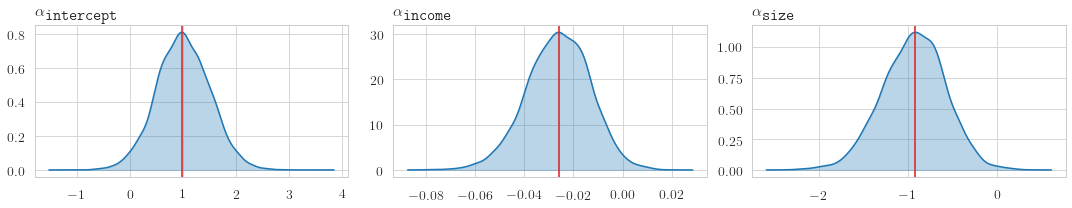

In [52]:
alpha_chain_plot(df_theta_adapt_smc, weights_RI)
plt.savefig('../Figures/alpha_adapt_smc.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')

In [53]:
def beta_chain_plot(df_theta_chain, weight):
    sns.set_style('whitegrid')
    # use latex and set font
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    for i, ax in enumerate(axes.flat):
        # =======
        # Density
        # =======
        weighted = sm.nonparametric.KDEUnivariate(df_theta_chain['beta_{}'.format(i+1)])
        weighted.fit(fft=False, weights=weight)
        # get mode
        mode = weighted.support[weighted.density.argmax()]
        # plot density
        ax.plot(weighted.support, weighted.density)
        # fill density
        ax.fill_between(weighted.support, weighted.density, color=colors[0], alpha=0.3)
        # plot mean estimate
        ax.axvline(mode, lw=2, color=colors[3], alpha=.8)
        
        ax.set_ylabel(r'')
        #axes[i].axvline(theta_init[i], lw=2, color=colors[2], alpha=.8, label='{prefix}prior mean'.format(prefix='' if i==0 else '_'))
        
        ax.tick_params(labelsize=14, pad=10)

    axes[0,0].set_title(r'$\beta_{\texttt{vcost}}(\omega_1)$', fontsize=16, loc='left')
    axes[0,1].set_title(r'$\beta_{\texttt{wait}}(\omega_1)$', fontsize=16, loc='left')
    axes[1,0].set_title(r'$\beta_{\texttt{vcost}}(\omega_2)$', fontsize=16, loc='left')
    axes[1,1].set_title(r'$\beta_{\texttt{wait}}(\omega_2)$', fontsize=16, loc='left')
    
    #lgd = plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, -.04), ncol=2, fontsize=16)
    plt.tight_layout()

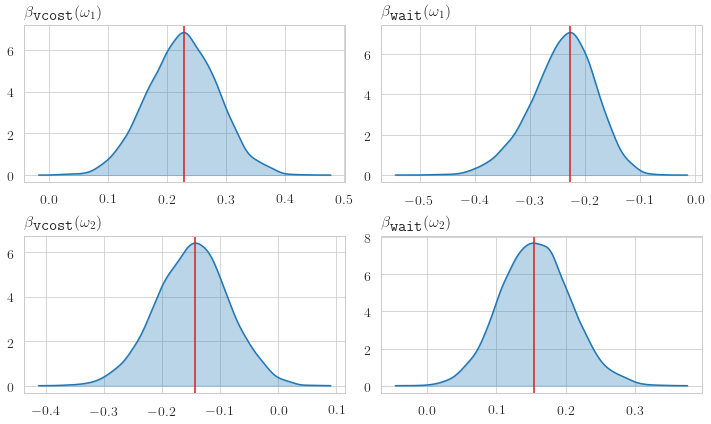

In [54]:
beta_chain_plot(df_theta_adapt_smc, weights_RI)
#plt.savefig('../Figures/beta_adapt_smc.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')

In [55]:
df_theta_adapt_smc.quantile([.025, .975])

,alpha_1,alpha_2,alpha_3,beta_1,beta_2,beta_3,beta_4
0.025,-0.052682,-0.054698,-1.695389,0.103013,-0.376415,-0.278353,0.055483
0.975,2.013410,-0.000879,-0.244664,0.345793,-0.134525,-0.023312,0.261667


In [56]:
df_theta_adapt_smc.cov()

,alpha_1,alpha_2,alpha_3,beta_1,beta_2,beta_3,beta_4
alpha_1,0.278111,-0.002166,-0.073608,-0.002043,-0.002736,0.003127,-0.000800
alpha_2,-0.002166,0.000191,-0.000892,0.000039,0.000022,-0.000024,-0.000055
alpha_3,-0.073608,-0.000892,0.139986,0.001419,-0.000126,0.000986,-0.001138
beta_1,-0.002043,0.000039,0.001419,0.003839,-0.001035,-0.000396,-0.000213
beta_2,-0.002736,0.000022,-0.000126,-0.001035,0.003836,-0.000286,-0.000281
beta_3,0.003127,-0.000024,0.000986,-0.000396,-0.000286,0.004241,-0.000116
beta_4,-0.000800,-0.000055,-0.001138,-0.000213,-0.000281,-0.000116,0.002761


## Get weighted quantiles based on the particle weights 

In [66]:
# code from StackExchange -- https://stackoverflow.com/a/29677616

def weighted_quantile(values, quantiles, sample_weight=None, values_sorted=False, old_style=False):
    """ Very close to np.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: np.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :param old_style: if True, will correct output to be consistent with np.percentile.
    :return: np.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with np.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [79]:
quant_weight = df_weights_adapt_smc.copy().iloc[-1,:].values
tab_len = 40

for i, var in enumerate(df_theta_adapt_smc.columns):
    print('='*tab_len)
    print('Parameter: {}'.format(var))
    print('-'*tab_len)
    print(' '*10, 'mode: {:.4f}'.format(theta_RI_mode[i]))
    print('-'*tab_len)
    quant = weighted_quantile(df_theta_adapt_smc[var].values, [.025, .975], sample_weight=quant_weight)
    print(' '*10, 'quantiles: [{:.4f}, {:.4f}]'.format(quant[0], quant[1]))

Parameter: alpha_1
----------------------------------------
           mode: 0.9737
----------------------------------------
           quantiles: [0.0282, 1.9930]
Parameter: alpha_2
----------------------------------------
           mode: -0.0260
----------------------------------------
           quantiles: [-0.0525, -0.0023]
Parameter: alpha_3
----------------------------------------
           mode: -0.9176
----------------------------------------
           quantiles: [-1.6480, -0.2737]
Parameter: beta_1
----------------------------------------
           mode: 0.2287
----------------------------------------
           quantiles: [0.1118, 0.3435]
Parameter: beta_2
----------------------------------------
           mode: -0.2268
----------------------------------------
           quantiles: [-0.3658, -0.1371]
Parameter: beta_3
----------------------------------------
           mode: -0.1428
----------------------------------------
           quantiles: [-0.2727, -0.0279]
Paramet

# Substitution Patterns

## Elasticities of choice probabilities with respect to changes in covariates

## (1) Latent Class Logit

In [80]:
def lc_choice_prob(beta, x_A):
    '''Logistic choice probabilities for classes.'''
    # get payoffs of alternatives for each classes -- statesXactions
    V = payoff(beta, x_A)
    return np.exp(V) / np.exp(V).sum(axis=1)[:, np.newaxis]


In [81]:
def lc_elast_ind(z, x_A, theta):
    '''Computes elasticities of choice probabilities
    with respect to changes in individual specific covariates.'''
    # split parameter vector
    alpha = theta[:(J-1)*p_z]
    alpha_ext = np.hstack((np.zeros(p_z), theta[:(J-1)*p_z]))
    beta = theta[(J-1)*p_z:]
    
    # get mean of the alpha parameters -- taking into account zeros for state 1
    mu = prior(alpha, z)
    alpha_mean = (alpha_ext.reshape((J, p_z)) * mu[:, np.newaxis]).sum(axis=0)
    
    alpha_centered = (alpha_ext - np.tile(alpha_mean, J)).reshape((J, p_z))
    
    # get logistic choice probabilities given classes
    P_s = lc_choice_prob(beta, x_A)
    # unconditional probabilities
    P = mu@P_s
    
    E = np.zeros((p_z, N))                                                              
    for state in range(J):
        E += np.kron((mu[state] * alpha_centered[state,:])[:,np.newaxis], P_s[state,:])
        
    return E#*np.kron(z[:,np.newaxis], 1/P)

In [82]:
def lc_elast_alt(z, x_A, theta):
    '''Computes elasticities of choice probabilities
    with respect to changes in alternative specific covariates.'''
    # split parameter vector
    alpha = theta[:(J-1)*p_z]
    beta = theta[(J-1)*p_z:]
    
    # state probabilities
    mu = prior(alpha, z)
    
    # get logistic choice probabilities given classes
    P_s = lc_choice_prob(beta, x_A)
    # unconditional probabilities
    P = mu@P_s
    # shape parmaeter to statesXcovariates matrix
    beta_matrix = beta.reshape((J, p_x))
    
    E = np.zeros((N*p_x, N))
    D = np.zeros((N*p_x, N))
    for state in range(J):
        E += np.kron(np.outer(P_s[state,:], P_s[state,:]), -mu[state]*beta_matrix[state,:][:, np.newaxis])
        D += block_diag(*[np.kron(P_s[state,:], mu[state]*beta_matrix[state,:][:, np.newaxis])[:, action][:,np.newaxis] 
                          for action in range(N)])
    
    
    return (E+D)#*np.kron(x_A[:,np.newaxis], 1/P)

In [83]:
alpha_lc = np.array([1.27635208, -0.03049587, -0.74181459])

beta_lc = np.array([0.06488313, -0.08553905,
                   -0.05056064,  0.03222663])

theta_lc = np.hstack((alpha_lc, beta_lc))

In [84]:
len(df_cov.index.unique())

210

In [85]:
# average elasticities
N_ind = len(df_cov.index.unique())

ave_lc_elast_ind = np.zeros((p_z, N))
ave_lc_elast_alt = np.zeros((N*p_x, N))
for row in df_cov.itertuples():
    # get choice set covaraites
    x_A = np.asarray(row[1:-3], dtype=np.float64)

    # get individual covariates
    z = np.asarray(row[-3:], dtype=np.float64)

    ave_lc_elast_ind += (1/N_ind)*lc_elast_ind(z, x_A, theta_lc)
    ave_lc_elast_alt += (1/N_ind)*lc_elast_alt(z, x_A, theta_lc)

In [86]:
ave_lc_elast = np.vstack((ave_lc_elast_ind, ave_lc_elast_alt))

In [87]:
#print(pd.DataFrame(ave_lc_elast_ind[1:,:]).round(5).to_latex())
pd.DataFrame(ave_lc_elast_ind[1:,:]).round(5)

,0,1,2,3
0,0.00079,-0.00226,0.00140,0.00006
1,0.01933,-0.05489,0.03415,0.00141


In [88]:
#print(pd.DataFrame(ave_lc_elast_alt).round(5).to_latex())
pd.DataFrame(ave_lc_elast_alt*100).round(5)

,0,1,2,3
0,0.35691,0.03521,-0.26177,-0.13035
1,-0.55209,-0.00591,0.36536,0.19264
2,0.03521,-0.17251,0.04494,0.09236
3,-0.00591,-0.00402,0.04150,-0.03157
4,-0.26177,0.04494,0.59422,-0.37739
5,0.36536,0.04150,-0.94782,0.54096
6,-0.13035,0.09236,-0.37739,0.41539
7,0.19264,-0.03157,0.54096,-0.70204


## Elasticities of choice probabilities with respect to changes in covariates

## (2) Endogenous Information Acquisition

Similar to getting the gradient with respect to parameters we use the implicit function theorem to derive the gradient with respect to covariates.


In order to get the gradient of $P^*$---given by a fixed point problem $F(z, x_A, P^*) = \mathbf{0}$---we make use of the implicit function theorem.

$$
\begin{align}
&F\colon \mathbb{R}^{dim(\alpha)}\times \mathbb{R}^{dim(\beta)} \times \mathbb{R}^{dim(P)} \mapsto \mathbb{R}^{dim(P)} \\
&F(z, x_A, P^*) = \mathbf{0}
\end{align}
$$

Let $zx := (z, x_A)$.

---
 
$$
\begin{align}
(D_{zx} F) + (D_{P} F)' (D_{zx} P^*) &= \mathbf{0} \nonumber \\
[D_{zx} P^* ]_{N\times d} &= \left[(D_{P} F)'^{-1}\right]_{N\times N} \left[(D_{zx} F)\right]_{N\times d}
\end{align}
$$
 
where 
 
$$(D_{zx} F) = [(D_z F), (D_{x_A} F)]$$

$D_{P} F$

In [89]:
def grad_p(mu, U, P):
    '''Returns gradient of fixed point equation
    with respect to unconditional probability.'''
    u_exp = np.exp(U)
    grad = np.diag(mu@(u_exp / (u_exp * P).sum(axis=1)[:, np.newaxis]) - 1)
    for a in range(len(P)):
        grad[a,:] -= mu@((u_exp / (u_exp * P).sum(axis=1)[:, np.newaxis]**2)[:,np.newaxis,a] * (u_exp * P))
    
    return grad

In [90]:
def grad_z(mu, U, P, alpha):
    '''Returns gradient of fixed point equation
    with respect to alpha.'''
    # split parameter vector
    alpha_ext = np.hstack((np.zeros(p_z), alpha))
    
    # get mean of the alpha parameters -- taking into account zeros for state 1
    alpha_mean = (alpha_ext.reshape((J, p_z)) * mu[:, np.newaxis]).sum(axis=0)
    
    alpha_centered = (alpha_ext - np.tile(alpha_mean, J)).reshape((J, p_z))
    
    u_exp = np.exp(U)
    P_cond = (u_exp * P) / (u_exp * P).sum(axis=1)[:, np.newaxis]
    
    E = np.zeros((p_z, N))                                                              
    for state in range(J):
        E += np.kron((mu[state] * alpha_centered[state,:])[:,np.newaxis], P_cond[state,:])

    return -E

In [91]:
def grad_x(mu, U, P, beta):
    '''Returns gradient of fixed point equation
    with respect to beta.'''
    
    u_exp = np.exp(U)
    P_cond = (u_exp * P) / (u_exp * P).sum(axis=1)[:, np.newaxis]
    # shape parmaeter to statesXcovariates matrix
    beta_matrix = beta.reshape((J, p_x))
    
    E = np.zeros((N*p_x, N))
    D = np.zeros((N*p_x, N))
    for state in range(J):
        E += np.kron(np.outer(P_cond[state,:], P_cond[state,:]), -mu[state]*beta_matrix[state,:][:, np.newaxis])
        D += block_diag(*[np.kron(P_cond[state,:], mu[state]*beta_matrix[state,:][:, np.newaxis])[:, action][:,np.newaxis] 
                          for action in range(N)])
      
    return -(E+D)

In [92]:
def gradient_zx(theta, P, z, x_A):
    '''Returns the gradient of the unconditional probability vector
    at a given observation using the implicit function theorem.'''
    # split parameter vector
    alpha = theta[:(J-1)*p_z]
    beta = theta[(J-1)*p_z:]
    # =================================
    # get the prior state probabilities
    mu = prior(alpha, z)
    # =================
    # get payoff matrix
    U = payoff(beta, x_A)
    # ====================================================
    # use implicit function theorem on implicit function F
    d_z_F = grad_z(mu, U, P, alpha).T
    d_x_F = grad_x(mu, U, P, beta).T
    d_P_F = grad_p(mu, U, P)
    # ===============
    # return gradient
    return np.linalg.inv(d_P_F.T)@np.hstack((d_z_F, d_x_F))

In [93]:
def elasticity_RI(theta):
    '''Average gradient with respect to covariates.'''
    # average elasticities
    N_ind = len(df_cov.index.unique())

    # split parameter vector
    alpha = theta[:(J-1)*p_z]
    beta = theta[(J-1)*p_z:]

    ave_RI_elast = np.zeros((N, p_z+N*p_x))
    
    for row in df_cov.itertuples():
        # get choice set covaraites
        x_A = np.asarray(row[1:-3], dtype=np.float64)

        # get individual covariates
        z = np.asarray(row[-3:], dtype=np.float64)

        # compute optimal unconditional prob.
        P = Blahut_Arimoto(payoff(beta, x_A), prior(alpha, z))

        ave_RI_elast += (1/N_ind)*gradient_zx(theta, P, z, x_A)
    
    return ave_RI_elast.T

In [94]:
theta_RI_mode

array([ 0.97369643, -0.02602366, -0.91755095,  0.22866151, -0.22677771,
       -0.14280908,  0.15360951])

In [95]:
EL_RI = elasticity_RI(theta_RI_mode)

In [96]:
pd.DataFrame(EL_RI[1:,:]).round(4)

,0,1,2,3
0,0.0004,-0.0027,0.0017,0.0006
1,0.0148,-0.0952,0.0595,0.0209
2,-0.0003,0.0001,0.0002,0.0000
3,0.0003,-0.0001,-0.0002,-0.0000
4,0.0001,-0.0002,0.0001,0.0001
5,-0.0001,0.0002,-0.0001,-0.0001
6,0.0002,0.0001,-0.0003,0.0000
7,-0.0002,-0.0001,0.0003,-0.0000
8,0.0000,0.0001,0.0000,-0.0001
9,-0.0000,-0.0001,-0.0000,0.0001


In [97]:
scale = np.array([10, 1, 10, 30, 10, 30, 10, 30, 10, 30])[:, np.newaxis]

index = ['\texttt{income}', '\texttt{size}', '$\texttt{vcost}^{\texttt{air}}$', '$\texttt{wait}^{\texttt{air}}$',
         '$\texttt{vcost}^{\texttt{bus}}$ ', '$\texttt{wait}^{\texttt{bus}}$', '$\texttt{vcost}^{\texttt{car}}$ ',
         '$\texttt{wait}^{\texttt{car}}$ ', '$\texttt{vcost}^{\texttt{train}}$', '$\texttt{wait}^{\texttt{train}}$']

ave_elast = np.hstack((ave_lc_elast, EL_RI))[1:,:]

pd.DataFrame(ave_elast*scale, index=index).round(6)

#print(pd.DataFrame(ave_elast*scale)[1:,:], index=index).round(4).to_latex(encoding='utf-8', escape=False))

,0,1,2,3,4,5,6,7
\texttt{income},0.007946,-0.022564,0.014039,0.000579,0.004207,-0.027013,0.016872,0.005934
\texttt{size},0.019329,-0.054886,0.034150,0.001407,0.014833,-0.095242,0.059488,0.020921
$\texttt{vcost}^{\texttt{air}}$,0.035691,0.003521,-0.026177,-0.013035,-0.003044,0.000503,0.002119,0.000421
$\texttt{wait}^{\texttt{air}}$,-0.165627,-0.001774,0.109607,0.057793,0.009994,-0.001627,-0.007000,-0.001367
$\texttt{vcost}^{\texttt{bus}}$,0.003521,-0.017251,0.004494,0.009236,0.000503,-0.002125,0.000701,0.000921
$\texttt{wait}^{\texttt{bus}}$,-0.001774,-0.001205,0.012450,-0.009471,-0.001627,0.006876,-0.002275,-0.002974
$\texttt{vcost}^{\texttt{car}}$,-0.026177,0.004494,0.059422,-0.037739,0.002119,0.000701,-0.002869,0.000048
$\texttt{wait}^{\texttt{car}}$,0.109607,0.012450,-0.284347,0.162289,-0.007000,-0.002275,0.009431,-0.000156
$\texttt{vcost}^{\texttt{train}}$,-0.013035,0.009236,-0.037739,0.041539,0.000421,0.000921,0.000048,-0.001390
$\texttt{wait}^{\texttt{train}}$,0.057793,-0.009471,0.162289,-0.210611,-0.001367,-0.002974,-0.000156,0.004496


In [98]:
pd.DataFrame(ave_elast*scale, index=index).round(6)

,0,1,2,3,4,5,6,7
\texttt{income},0.007946,-0.022564,0.014039,0.000579,0.004207,-0.027013,0.016872,0.005934
\texttt{size},0.019329,-0.054886,0.034150,0.001407,0.014833,-0.095242,0.059488,0.020921
$\texttt{vcost}^{\texttt{air}}$,0.035691,0.003521,-0.026177,-0.013035,-0.003044,0.000503,0.002119,0.000421
$\texttt{wait}^{\texttt{air}}$,-0.165627,-0.001774,0.109607,0.057793,0.009994,-0.001627,-0.007000,-0.001367
$\texttt{vcost}^{\texttt{bus}}$,0.003521,-0.017251,0.004494,0.009236,0.000503,-0.002125,0.000701,0.000921
$\texttt{wait}^{\texttt{bus}}$,-0.001774,-0.001205,0.012450,-0.009471,-0.001627,0.006876,-0.002275,-0.002974
$\texttt{vcost}^{\texttt{car}}$,-0.026177,0.004494,0.059422,-0.037739,0.002119,0.000701,-0.002869,0.000048
$\texttt{wait}^{\texttt{car}}$,0.109607,0.012450,-0.284347,0.162289,-0.007000,-0.002275,0.009431,-0.000156
$\texttt{vcost}^{\texttt{train}}$,-0.013035,0.009236,-0.037739,0.041539,0.000421,0.000921,0.000048,-0.001390
$\texttt{wait}^{\texttt{train}}$,0.057793,-0.009471,0.162289,-0.210611,-0.001367,-0.002974,-0.000156,0.004496


In [99]:
print(pd.DataFrame(ave_elast*scale, index=index).round(3).to_latex(encoding='utf-8', escape=False))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &      0 &      1 &      2 &      3 &      4 &      5 &      6 &      7 \\
\midrule
\texttt{income}                   &  0.008 & -0.023 &  0.014 &  0.001 &  0.004 & -0.027 &  0.017 &  0.006 \\
\texttt{size}                     &  0.019 & -0.055 &  0.034 &  0.001 &  0.015 & -0.095 &  0.059 &  0.021 \\
$\texttt{vcost}^{\texttt{air}}$   &  0.036 &  0.004 & -0.026 & -0.013 & -0.003 &  0.001 &  0.002 &  0.000 \\
$\texttt{wait}^{\texttt{air}}$    & -0.166 & -0.002 &  0.110 &  0.058 &  0.010 & -0.002 & -0.007 & -0.001 \\
$\texttt{vcost}^{\texttt{bus}}$   &  0.004 & -0.017 &  0.004 &  0.009 &  0.001 & -0.002 &  0.001 &  0.001 \\
$\texttt{wait}^{\texttt{bus}}$    & -0.002 & -0.001 &  0.012 & -0.009 & -0.002 &  0.007 & -0.002 & -0.003 \\
$\texttt{vcost}^{\texttt{car}}$   & -0.026 &  0.004 &  0.059 & -0.038 &  0.002 &  0.001 & -0.003 &  0.000 \\
$\texttt{wait}^{\texttt{car}}$    &  0.110 &  0.012 & -0.284 &  0.162 & -0.007 & -0.002 &  0.009 & -0.000 \\
$\tex